# X To A Testis 2

In [12]:
import os
import sys
from pathlib import Path

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Project level imports
sys.path.insert(0, '../lib')
from larval_gonad.notebook import Nb
from larval_gonad.plotting import make_figs
from larval_gonad.config import memory
from larval_gonad.x_to_a import CHROMS_CHR, AUTOSOMES_CHR, commonly_expressed, multi_chrom_boxplot

# Setup notebook
nbconfig = Nb.setup_notebook('2018-03-27_x2a_testis2', seurat_dir='../output/testis2_scRNAseq')

last updated: 2018-03-28 
Git hash: fd4bbba44352ed860ddf0d51ee1903603d7e2dff


In [33]:
clusters = nbconfig.seurat.get_clusters()
clus6 = clusters['res.0.6']

In [34]:
soma = [2, 9, 10]
early = [4, 8]
late = [0, 3, 5, 7]

# House Keeping

In [35]:
norm = nbconfig.seurat.get_normalized_read_counts()

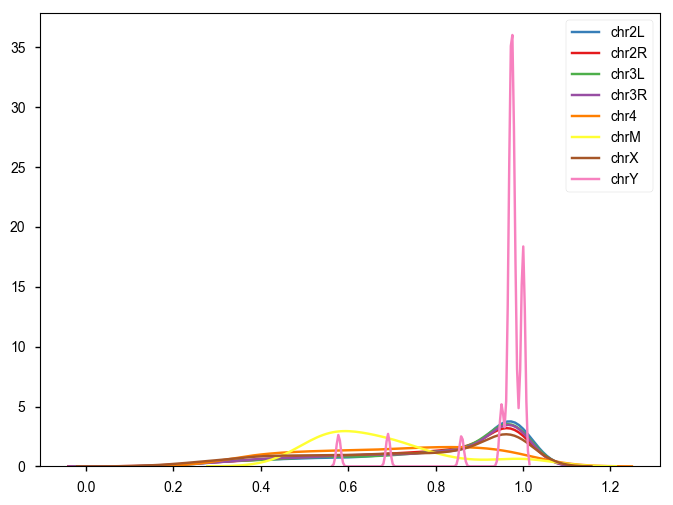

In [29]:
tau = pd.read_csv('../output/2018-02-05_tau_haiwang_male_tau.tsv', sep='\t', index_col='FBgn').dropna()
for i, g in tau.join(nbconfig.fbgn2chrom).groupby('chrom'):
    sns.kdeplot(g.tau, label=i)

In [54]:
housekeeping = tau[tau.tau > 0.7].index
housekeeping.shape

(10268,)

In [55]:
expressed = norm.index[norm.index.isin(housekeeping)]

In [71]:
norm.head()

,AAACCTGCACCTCGTT,AAACCTGCAGACTCGC,AAACCTGCATCGGTTA,AAACCTGTCGTATCAG,AAACGGGAGCAATATG,AAACGGGAGTAGCCGA,AAACGGGCAAACCCAT,AAACGGGCAGATCGGA,AAACGGGCAGGTCTCG,AAACGGGGTATTCTCT,...,TTTCCTCCAGGGTACA,TTTCCTCGTTGCCTCT,TTTGCGCCAACTGGCC,TTTGGTTCAGGGTACA,TTTGGTTCATGCTGGC,TTTGGTTTCAGCATGT,TTTGTCAAGACTAGAT,TTTGTCAAGGTGACCA,TTTGTCAGTCATGCAT,TTTGTCATCTGCGTAA
FBgn,,,,,,,,,,,,,,,,,,,,,
FBgn0031081,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.043421
FBgn0031085,2.141233,0.713766,2.268787,0.567006,2.115343,0.000000,0.971754,2.357848,1.776318,0.964931,...,0.000000,0.000000,2.158763,2.195049,2.017590,1.499032,0.892376,0.000000,2.427623,0.000000
FBgn0040784,0.429457,0.713766,0.468609,0.926621,1.050671,0.000000,0.000000,1.094468,1.497737,0.000000,...,1.316009,0.000000,0.518528,1.154328,1.141917,1.283158,1.356310,0.925264,1.276194,0.000000
FBgn0031086,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
FBgn0031082,0.728923,0.713766,0.893886,0.323163,0.756275,0.921512,0.000000,0.678381,0.787133,0.000000,...,0.000000,0.875784,0.933910,0.723042,0.824027,0.000000,0.000000,0.000000,0.000000,0.000000


In [94]:
expressed = norm[((norm > 0).sum(axis=1) > 1200)].index

In [95]:
data = norm.loc[expressed, :].T.join(clus6)
data.rename({'res.0.6': 'cluster'}, axis=1, inplace=True)

In [96]:
dat = data.groupby('cluster').median().T.reset_index()\
    .melt(id_vars='index')\
    .merge(nbconfig.fbgn2chrom, left_on='index', right_index=True)\
    .set_index('index')

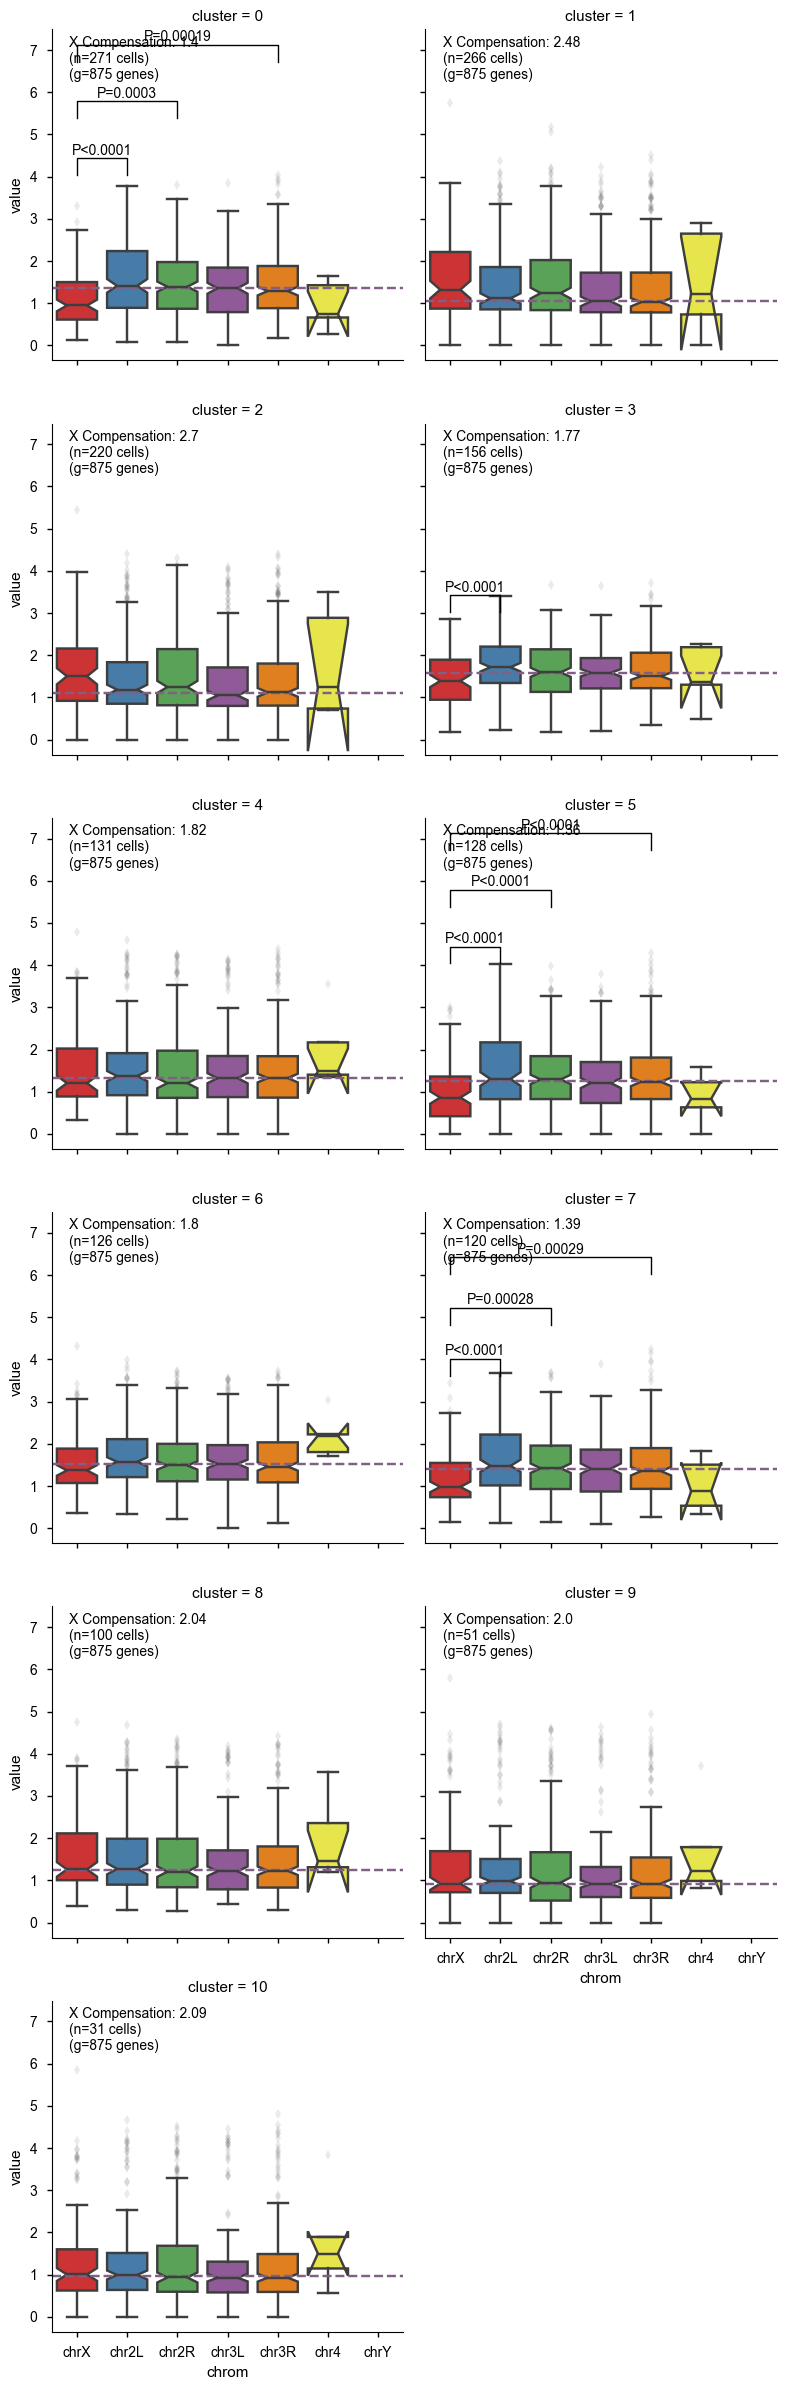

In [97]:
def _plot(dat):
    num_cells = data.groupby('cluster').count().iloc[:, 0].to_dict()
    g = sns.FacetGrid(dat, col='cluster', col_wrap=2, size=4)
    g.map_dataframe(multi_chrom_boxplot, 'chrom', 'value', num_cells=num_cells, palette=nbconfig.color_chrom, 
                    notch=True, flierprops=nbconfig.fliersprops)
    #g.set(ylim=(0, 600))

_plot(dat)

In [8]:
Ydata = norm.join(nbconfig.fbgn2chrom).query('chrom == "chrY"').drop('chrom', axis=1)
Ydata = Ydata.T.loc[clus6.sort_values().index]

In [9]:
Ydata.columns = Ydata.columns.map(lambda x: nbconfig.fbgn2symbol[x])

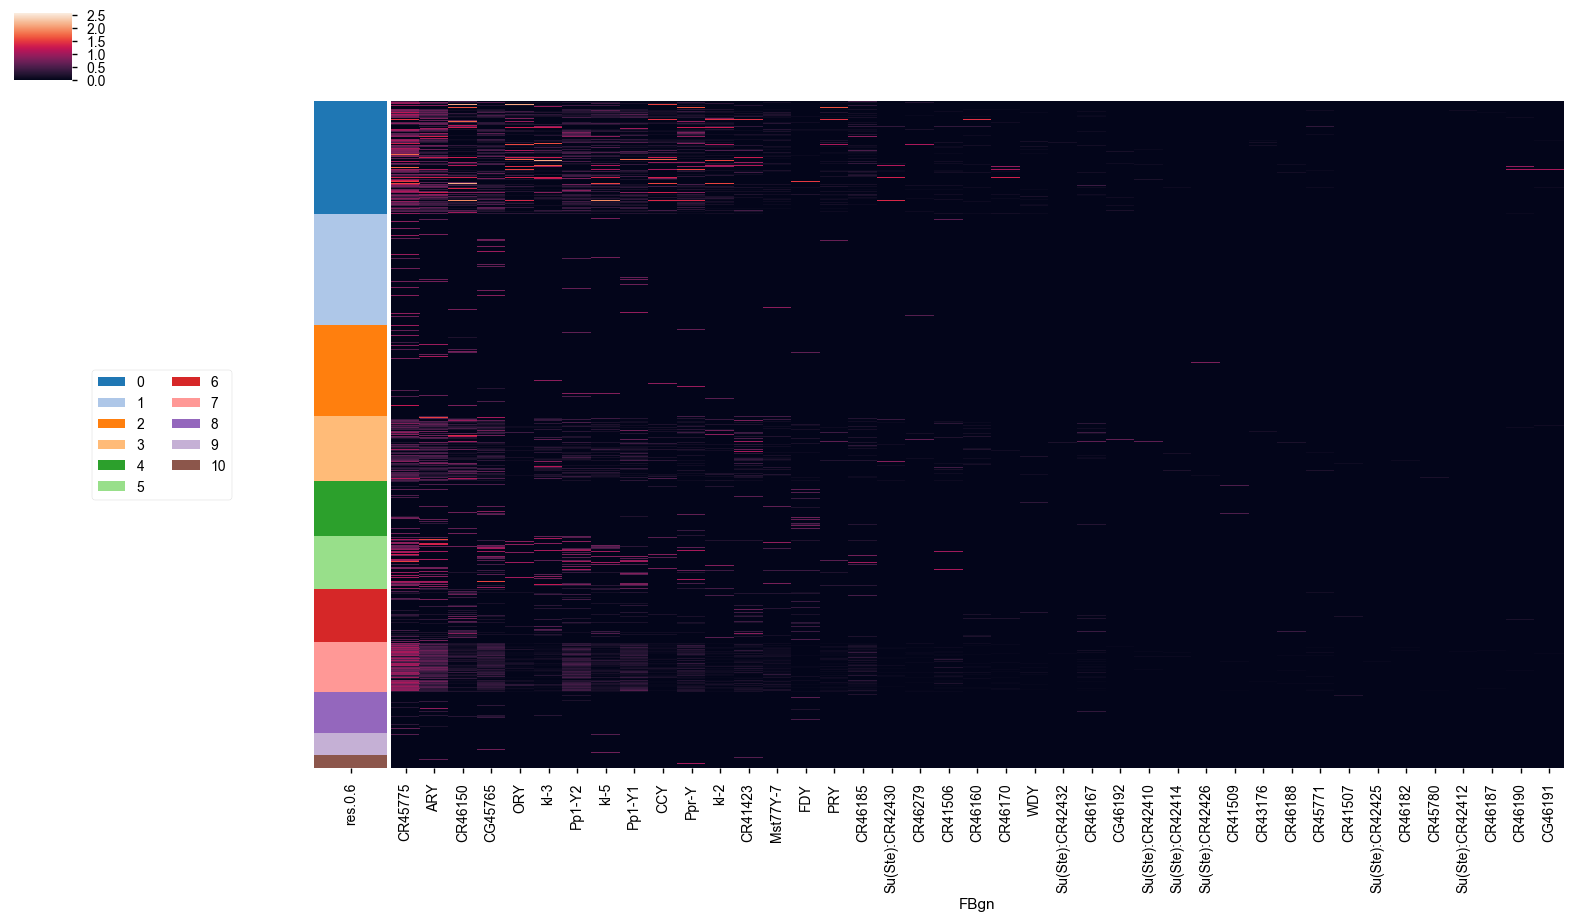

In [18]:
levels = sorted(clus6.unique())
colors = sns.color_palette('tab20', n_colors=len(levels))
mapper = dict(zip(levels, colors))
cmap = clus6.sort_values().map(mapper)

g = sns.clustermap(Ydata, row_cluster=False, col_cluster=True, yticklabels=False, row_colors=cmap, figsize=(20, 10))
g.ax_col_dendrogram.set_visible(False)

for label in levels:
    g.ax_row_dendrogram.bar(0, 0, color=mapper[label],
                            label=label, linewidth=0)
g.ax_row_dendrogram.legend(loc="center", ncol=2)

In [14]:
soma = clus12[clus12 == 13].index.tolist()
early = clus12[clus12 == 8].index.tolist()
late = clus12[clus12 == 6].index.tolist()

In [15]:
from larval_gonad.x_to_a import estimate_dcc, clean_pvalue

In [16]:
from scipy.stats import mannwhitneyu

In [37]:
def boxplot(data, expressed, mask, chrom, ax, name):
    _data = data.loc[expressed, mask]
    _data['median'] = _data.median(axis=1)
    _data = _data.join(chrom, how='inner')
    med_x, med_major, prop_dcc = estimate_dcc('chrom', 'median', _data)

    _data['chrom'] = _data['chrom'].map(lambda x: x.replace('chr', ''))
    
    ORDER = ['X', '2L', '2R', '3L', '3R', '4']
    sns.boxplot(_data['chrom'], _data['median'], order=ORDER, notch=True, boxprops={"facecolor": 'w'}, ax=ax, flierprops={'alpha': .6})
    ax.axhline(med_major, ls=':', lw=2, color=nbconfig.color_c1)
    ax.set_title(name)
    ax.set_xlabel('Chromosome')
    ax.set_ylabel('Median Normalized Expression')
    
    # Clean up the pvalue for plotting
    pvalues = {}
    iqr = 0
    chromX = _data[_data.chrom == 'X']
    for g, df in _data.groupby('chrom'):
        _iqr = sns.utils.iqr(df['median'])
        if _iqr > iqr:
            iqr = _iqr
        if g == 'X':
            continue
        if g == 'M':
            continue
        _, pval = mannwhitneyu(chromX['median'], df['median'], alternative='two-sided')
        if pval <= 0.001:
            pvalues[g] = '***'

    multiplier = .35
    xloc = ORDER.index('X')
    for k, v in pvalues.items():
        oloc = ORDER.index(k)
        pval = v
        y, h, col = iqr + iqr * multiplier, .1, 'k'
        plt.plot([xloc, xloc, oloc, oloc], [y, y+h, y+h, y], lw=1, c=col)
        plt.text((xloc+oloc)*.5, y+h+.01, f"{pval}", ha='center',
                 va='bottom', color=col)
        multiplier += .2

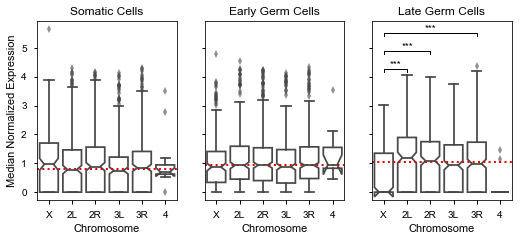

In [41]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8.5, 3.3), sharex=True, sharey=True)
chrom = nbconfig.fbgn2chrom
boxplot(norm, expressed, soma, chrom, ax1, 'Somatic Cells')
boxplot(norm, expressed, early, chrom, ax2, 'Early Germ Cells')
boxplot(norm, expressed, late, chrom, ax3, 'Late Germ Cells')
ax2.set_ylabel('')
ax3.set_ylabel('')
plt.savefig('../output/figures/2018-03-16_x2a_combined_forced_simple_boxplot.png', dpi=300)
